# Video Caption
* Source code come from : xiadingZ/video-caption.pytorch
* github: https://github.com/xiadingZ/video-caption.pytorch

# Note: you can get better image features by CNN 
![](./image/s2vt.png)

# 注意：
#### 網路 video caption 相關程式都包的太好而不好理解，這裡簡單重寫並只保留主軸以便說明！！

In [1]:
# special package <conda install>
import cv2 as cv
import imageio
import nltk

In [2]:
import json  
import pickle
import collections
from collections import Counter  

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Input data - video (.avi file)
* Dataset： MSVD 
-	1450 videos for training / 100 videos for testing
* Download: https://drive.google.com/file/d/1zDzkDpN0fXf1gBclH0yqLWaKat1AVfo7/view

In [4]:
# database folder
path = './video_data/training_data/video/'

# dictionary of video_name-index
avi_idx = {}
for idx, avi in enumerate(os.listdir(path)):
    avi_idx[avi]=idx

# Video preprocessing
#### video  =>  a sequence of images
* Opencv: import cv2 as cv
* imageio: import imageio

In [5]:
def get_image(size=64, frame=30):
    '''
    size:  image size
    frame: image amounts of each video
    '''
    train_data = np.zeros((len(avi_idx), frame, size, size), dtype="float32")
    for i in range(len(avi_idx)):
        
        # reading video by imageio
        reader = imageio.get_reader(path + os.listdir(path)[i], "ffmpeg")

        # split video to several images by opencv
        for t in range(frame):
            img = cv.cvtColor(cv.resize(reader.get_data(t), (size, size)),
                              cv.COLOR_RGB2GRAY)
            train_data[avi_idx[os.listdir(path)[i]], t, :, :] = img[:, :]
    return train_data



def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2,2)
    plt.imshow(image) #, cmap='binary'
    plt.show()

In [ ]:
# input data (numpy array)
size=64
frame=30
train_input = get_image(size=size, frame=frame)

738


/home/eric/anaconda3/envs/pytorch_gpu/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


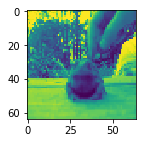

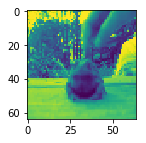

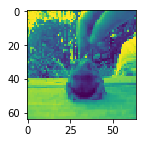

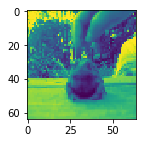

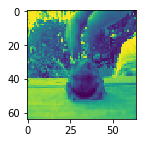

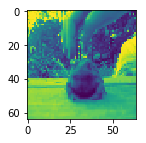

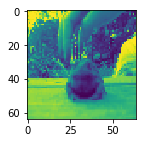

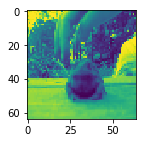

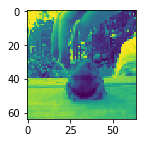

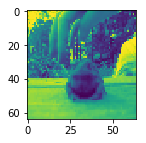

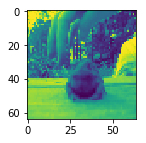

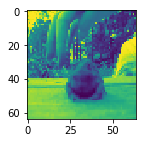

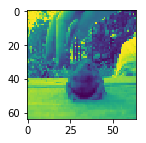

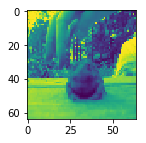

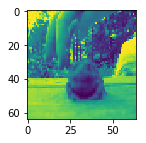

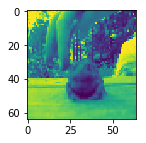

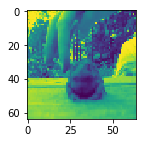

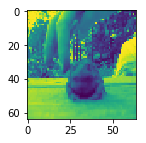

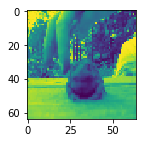

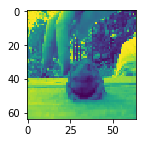

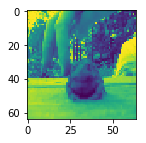

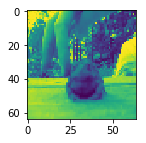

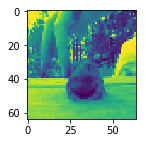

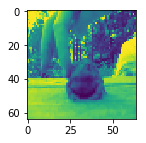

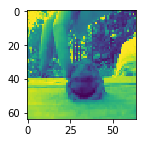

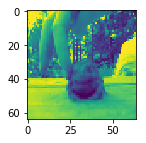

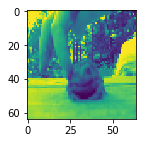

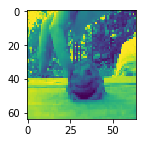

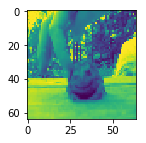

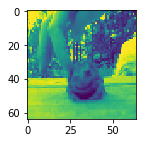

In [15]:
# randomly printing one input data
r = avi_idx['00jrXRMlZOY_0_10.avi']
print(r)
for i in range(frame):
    plot_image(train_input[r, i, :, :])

# Deal with Lable (caption)

In [16]:
# Read label data
with open('./video_data/training_label.json') as load_f:
    train_label = json.load(load_f)
print('Length of data: ', len(train_label))

Length of data:  1450


In [19]:
# view label: there are over 10 captions at each video
train_label[0]['caption']

['A woman goes under a horse.',
 'A woman crawls under a horse and gets a surprise.',
 'A girl is jutting out her head from between the back legs of a horse who shits on her head.',
 "A horse defecated on a woman's head.",
 'A horse excretes on the head of a woman as she gets in between the fore anf hind legs and sticks her head out.',
 "A horse is defecating on a woman's head.",
 'A horse poops on a woman.',
 'A horse poops on a woman.',
 "A lady was pooped on because she was under a horse's tail end.",
 'A woman crawls under a horse and when she sticks her head between the horses rear legs the horse defecates on her head.',
 "A woman goes under a horse's behind and gets pooped on.",
 'A woman goes underneath a horse.',
 'A woman is crawling under a horse.',
 'A woman is getting pooped on by a horse.',
 'A woman is walking between horse legs.',
 'A woman is walking under horse and it poops on her head.',
 'As the woman went underneath the horse, the horse pooped on her head.',
 'The h

In [21]:
# randomly pick one caption for each video
captions = {}
for dic in train_label:
    for cap in dic['caption']: 
        if len(cap.split(' '))>=9 and len(cap.split(' '))<= 11:
            break
        elif len(cap.split(' '))>=6 and len(cap.split(' '))<= 14:
            break
    captions[avi_idx[dic['id']]] = cap.lower()

In [22]:
captions[738]

'a person is itching a toad.'

# Make a word-index dict.
* from collections import Counter 
* import nltk => ('caption'.split(' '))

In [25]:
# count the no. of each word
counter = Counter()  
for cap in captions.values():
    tokens = nltk.tokenize.word_tokenize(cap, language='english', preserve_line=False) 
    counter.update(tokens)
print('word table length: ', len(counter))
counter 

word table length:  1855


Counter({'a': 2365,
         'woman': 245,
         'goes': 5,
         'under': 3,
         'horse': 24,
         '.': 1403,
         'man': 441,
         'slicing': 38,
         'butter': 6,
         'into': 142,
         'bowl': 53,
         'slow': 6,
         'loris': 4,
         'is': 771,
         'eating': 31,
         'an': 88,
         'egg': 13,
         'putting': 14,
         'pepper': 9,
         'someone': 118,
         'burning': 1,
         'the': 268,
         'tops': 1,
         'of': 226,
         'two': 78,
         'cameras': 1,
         'with': 159,
         'torch': 1,
         'clouds': 1,
         'are': 131,
         'quickly': 3,
         'floating': 3,
         'past': 1,
         'building': 3,
         'older': 3,
         'jewish': 1,
         'slowly': 3,
         'speaking': 3,
         'peeling': 20,
         'apple': 2,
         'doing': 29,
         'some': 27,
         'yoga': 1,
         'stretching': 1,
         'exercises': 4,
         'in': 274

In [28]:
# Create dictionary
char2idx = {'sos': 0, 'eos': 1, 'pad': 2, 'unk': 3}
idx2char = {0: 'sos', 1: 'eos', 2: 'pad', 3: 'unk'}
num_chars = 4

for char in counter.keys():
    char2idx[char] = num_chars
    idx2char[num_chars] = char
    num_chars += 1

In [ ]:
'''
other tokens：<PAD>, <BOS>, <EOS>, <UNK>  
-  <pad>  ：Pad the sentencen to the same length
-  <bos>  ：Begin of sentence, a sign to generate the output sentence.
-  <eos>  ：End of sentence, a sign of the end of the output sentence.
-  <unk> ：Use this token when the word isn’t in the dictionary or just ignore the unknown word.
'''

# Convert captions(string) to index(int)
* Adjust all captions to same length

In [29]:
def cap_to_idx(captions, max_length=15):
    """Transform a char sequence to index sequence
    """
    idx_captions = {}
    
    for idx, cap in captions.items():
        i = 0
        index_sequence = [char2idx['sos']] #start word
        for char in cap.split(' '):
            if char not in char2idx:
                index_sequence.append((char2idx['unk']))
            else:
                index_sequence.append(char2idx[char])
            i +=1
            if i >= 14: break
        while i <= 14:
            index_sequence.append(char2idx['pad'])
            i+=1
        index_sequence.append(char2idx['eos'])
        idx_captions[idx] = index_sequence
    return idx_captions



def idx_to_cap(indices):
    """Transform a list of indices
        :param indices: a list
    """
    sequence = ""
    for idx in indices:
        char = idx2char[idx]
        if char == "eos":
            break
        else:
            sequence = sequence + ' '+ char
    return sequence

In [31]:
# getting training label with same length
train_label = cap_to_idx(captions)
print(train_label[738])
print(idx_to_cap(train_label[738]))

[0, 4, 111, 17, 1203, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]
 sos a person is itching a unk pad pad pad pad pad pad pad pad pad


# Video - caption pair with batchs
### input size of rnn is (batch_size, seq_len, input_size) => (one_epoch, batch_size, seq_len, input_size)

In [32]:
import torch
from torch.autograd import Variable

def mini_batch(train_x, train_y, batch_size=50):

    mini_batches = []
    
    data_idx = np.array(list(train_label.keys()))
    np.random.shuffle(data_idx)
    one_epoch = int(len(train_x)/batch_size)
    
    # take each batch of data index 
    for k in range(one_epoch):
        mini_batches.append(data_idx[k*batch_size : (k+1)*batch_size])
    
    for each_batch in mini_batches:
        input_batch = []
        target_batch = []
        for idx in each_batch:
            input_batch.append(train_x[idx, :, :, :])
            target_batch.append(train_y[idx])
            
        input_batch = np.array(input_batch)
        shape = input_batch.shape
        input_batch = input_batch.reshape(shape[0],shape[1], shape[2]*shape[3])
        target_batch = np.array(target_batch)
        
        input_var = Variable(torch.FloatTensor(input_batch)) 
        target_var = Variable(torch.LongTensor(target_batch))
        yield input_var, target_var   

In [33]:
# check training data shape
input_data = mini_batch(train_input, train_label, batch_size=10)

for input_batch, target_batch in input_data:
    print(input_batch.shape)
    print(target_batch.shape)
    break

torch.Size([10, 30, 4096])
torch.Size([10, 17])


# Note: In pytorch, no need converting index to onehot
![](./image/no_onehot.png)

# pretrained image

In [35]:
import torchvision.models as models
# <pretrained=True> to get pretrained model


resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
# where H and W are expected to be at least 224. 

# seq2seq Model with Attentions

In [36]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# seq2seq

In [37]:
class S2VTAttModel(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(S2VTAttModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, vid_feats, target_variable=None):
        """
        vid_feats (Variable): video feats of shape [batch_size, seq_len, dim_vid]
        target_variable (None, optional): groung truth labels
        
        Returns:
            seq_prob: Variable of shape [batch_size, max_len-1, vocab_size]
            seq_preds: [] or Variable of shape [batch_size, max_len-1]
        """
        encoder_outputs, encoder_hidden = self.encoder(vid_feats)
        seq_prob, seq_preds = self.decoder(encoder_outputs, encoder_hidden, target_variable)
        return seq_prob, seq_preds

# Encoder

In [38]:
class EncoderRNN(nn.Module):
    def __init__(self, dim_vid, dim_hidden, input_dropout_p=0.2, rnn_dropout_p=0.5,
                 n_layers=1, bidirectional=False):
        """
        Args:
            hidden_dim (int): dim of hidden state of rnn
            input_dropout_p (int): dropout probability for the input sequence
            dropout_p (float): dropout probability for the output sequence
            n_layers (int): number of rnn layers
            rnn_cell (str): type of RNN cell ('LSTM'/'GRU')
        """
        super(EncoderRNN, self).__init__()
        
        # parameters of RNN model
        self.dim_vid = dim_vid
        self.dim_hidden = dim_hidden
        self.input_dropout_p = input_dropout_p
        self.rnn_dropout_p = rnn_dropout_p
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        # 
        self.vid2hid = nn.Linear(dim_vid, dim_hidden)
        self.input_dropout = nn.Dropout(input_dropout_p)
            
            
        # Initializing RNN model
        self.rnn = nn.GRU(dim_vid, dim_hidden, n_layers, batch_first=True,
                                bidirectional=bidirectional, dropout=self.rnn_dropout_p)


    def forward(self, vid_feats):
        batch_size, seq_len, dim_vid = vid_feats.size()
        vid_feats = vid_feats.view(batch_size, seq_len, dim_vid)
        self.rnn.flatten_parameters()
        
        output, hidden = self.rnn(vid_feats)
        return output, hidden

# Attention

In [39]:
class Attention(nn.Module):
    """
    Applies an attention mechanism on the output features from the decoder.
    """

    def __init__(self, dim):
        super(Attention, self).__init__()
        self.dim = dim
        self.linear1 = nn.Linear(dim * 2, dim)
        self.linear2 = nn.Linear(dim, 1, bias=False) 
        

    def forward(self, hidden_state, encoder_outputs):
        """
        Arguments:
            hidden_state {Variable} -- batch_size x dim
            encoder_outputs {Variable} -- batch_size x seq_len x dim
        Returns:
            Variable -- context vector of size batch_size x dim
        """
        batch_size, seq_len, _ = encoder_outputs.size()
        hidden_state = hidden_state.unsqueeze(1).repeat(1, seq_len, 1)
        
        # cat Encoder outputs and key condition
        inputs = torch.cat((encoder_outputs, hidden_state),2).view(-1, self.dim * 2)
        
        o = self.linear1(inputs) 
        o = F.tanh(o)            
        o = self.linear2(o)      
        e = o.view(batch_size, seq_len)
        
        alpha = F.softmax(e, dim=1) # weight
        context = torch.bmm(alpha.unsqueeze(1), encoder_outputs).squeeze(1)
        
        return context

# Decoder

In [40]:
class DecoderRNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 max_len,
                 dim_hidden,
                 dim_word,
                 n_layers=1,
                 bidirectional=False,
                 input_dropout_p=0.1,
                 rnn_dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        

        self.bidirectional_encoder = bidirectional
        self.dim_output = vocab_size
        self.dim_hidden = dim_hidden * 2 if bidirectional else dim_hidden
        self.dim_word = dim_word
        self.max_length = max_len
        
        # Initialization: Dropout / Embedding / Attention
        self.input_dropout = nn.Dropout(input_dropout_p)
        self.embedding = nn.Embedding(self.dim_output, dim_word)
        self.attention = Attention(self.dim_hidden)
            
        # Initializing RNN model
        self.rnn = nn.GRU( self.dim_hidden + dim_word,
                                  self.dim_hidden,
                                  n_layers,
                                  batch_first=True,
                                  dropout=rnn_dropout_p )
        
        self.out = nn.Linear(self.dim_hidden, self.dim_output)
        

    def forward( self,
                 encoder_outputs,
                 encoder_hidden,
                 targets=None,
                 opt={} ):
        
        sample_max = opt.get('sample_max', 1)
        beam_size = opt.get('beam_size', 1)
        temperature = opt.get('temperature', 1.0)

        batch_size, _, _ = encoder_outputs.size()
        
        # 
        decoder_hidden = self._init_rnn_state(encoder_hidden)

        
        seq_logprobs = []
        seq_preds = []
        
        self.rnn.flatten_parameters()
        targets_emb = self.embedding(targets)
        
        for i in range(self.max_length):
            current_words = targets_emb[:, i, :]
            
            # Get attention context by the condition of decoder_hidden
            context = self.attention(decoder_hidden.squeeze(0), encoder_outputs)
            
            # Decoder 
            decoder_input = torch.cat([current_words, context], dim=1)
            decoder_input = self.input_dropout(decoder_input).unsqueeze(1)          
            decoder_output, decoder_hidden = self.rnn(
                                                  decoder_input, decoder_hidden)
            # output
            logprobs = F.log_softmax(
                             self.out(decoder_output.squeeze(1)), dim=1)
            seq_logprobs.append(logprobs.unsqueeze(1))

        seq_logprobs = torch.cat(seq_logprobs, 1)
        return seq_logprobs, seq_preds
    
    
        

    def _init_rnn_state(self, encoder_hidden):
        """ Initialize the encoder hidden state. """
        if encoder_hidden is None:
            return None
        if isinstance(encoder_hidden, tuple):
            encoder_hidden = tuple(
                [self._cat_directions(h) for h in encoder_hidden])
        else:
            encoder_hidden = self._cat_directions(encoder_hidden)
        return encoder_hidden
    
    
    def _cat_directions(self, h):
        """ If the encoder is bidirectional, do the following transformation.
            (#directions * #layers, #batch, dim_hidden) -> (#layers, #batch, #directions * dim_hidden)
        """
        if self.bidirectional_encoder:
            h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
        return h

In [41]:
def get_loss(decoder_outputs, targets):
    b = decoder_outputs.size(0)
    t = decoder_outputs.size(1)
    targets = targets.contiguous().view(-1)  # S = (B*T)
    decoder_outputs = decoder_outputs.view(b * t, -1)  # S = (B*T) x V
    loss_func = nn.CrossEntropyLoss()
    return loss_func(decoder_outputs, targets)


def train(train_input, train_label, model, optimizer, opt):
    model.train()
    for epoch in range(2):
        input_data = mini_batch(train_input, train_label, batch_size=10)
        
        for fc_feats, target in input_data:
            # Training model
            optimizer.zero_grad()
            decoder_outputs, seq_preds = model(fc_feats, target)

            loss = get_loss(decoder_outputs, target)
            loss.backward()
            optimizer.step()
            

In [42]:
def main(opt, train_input, train_label, vocab_size):
    
    opt["vocab_size"] = vocab_size
    

    # Initializing Encoder model
    encoder = EncoderRNN(
        opt["dim_vid"],
        opt["dim_hidden"],
        input_dropout_p=opt["input_dropout_p"],
        rnn_dropout_p=opt["rnn_dropout_p"])
    
    # Initializing Dncoder model
    decoder = DecoderRNN(
        opt["vocab_size"],
        opt["max_len"],
        opt["dim_hidden"],
        opt["dim_word"],
        input_dropout_p=opt["input_dropout_p"],
        rnn_dropout_p=opt["rnn_dropout_p"])
    
    
    # Initializing seq2seq model
    model = S2VTAttModel(encoder, decoder) 
    
    
    optimizer = optim.Adam(
                      model.parameters(),
                      lr=opt["learning_rate"],
                      weight_decay=opt["weight_decay"])
    
    
    # Call 'train' function to training model
    train(train_input, train_label, model, optimizer, opt)

In [43]:
opt = { 'model': 'S2VTAttModel',
        'rnn_type': 'gru',
       
        'dim_hidden': 1024,
        'dim_word': 512,
        'dim_vid': 4096,
        'max_len': 17,
        
        'num_layers': 1,
        'input_dropout_p': 0.2,
        'rnn_dropout_p': 0.5,

        'learning_rate': 4e-4,
        'learning_rate_decay_every':200,
        'learning_rate_decay_rate': 0.8,
        'optim_alpha': 0.9,
        'optim_beta': 0.999,
        'optim_epsilon': 1e-8,
        'weight_decay': 5e-4,
}

In [ ]:
if __name__ == '__main__':
    main(opt, train_input, train_label, 2000)